## Load Packages

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import keras

#import matplotlib as mpl
import matplotlib.pyplot as plt
#import matplotlib.pyplot as pylab
#import seaborn as sns
#import plotly.offline as py
#import plotly.graph_objs as go
#py.init_notebook_mode(connected=True)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, GlobalAveragePooling1D, concatenate
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint 

import pickle
#import nltk
#import string
#from nltk.corpus import stopwords
#from sklearn.manifold import TSNE

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#from sklearn.metrics import f1_score, roc_auc_score, multilabel_confusion_matrix, average_precision_score, precision_recall_curve

Using TensorFlow backend.


## Load Dataset and Basic EDA

In [2]:
# List Classifier
train_labels = ['outwear','top','trousers','women dresses','women skirts']

In [3]:
# Reading csv file of train set
fashion_df = pd.read_csv("./datasets/TIL_NLP_train_dataset.csv")
fashion_df.dropna(inplace=True)
fashion_df.head(10)

,id,word_representation,outwear,top,trousers,women dresses,women skirts
0,0,w7718 w173355 w138132 w232277 w90685 w314686 w...,1,0,1,0,0
1,1,w195317 w127737 w171593 w22890 w342007 w217871...,1,0,1,0,0
2,2,w247655 w270233 w261113 w337250 w366000 w37873...,0,1,1,0,0
3,3,w279289 w395855 w61795 w286461 w308610 w27013 ...,1,0,1,0,0
4,4,w254516 w135431 w115724 w331534 w256214 w71240...,1,0,1,0,0
5,5,w53495 w306061 w372126 w47982 w66980 w189406 w...,1,0,0,0,1
6,6,w237465 w256553 w286461 w382662 w206066 w12125...,1,0,0,1,0
7,7,w173317 w39222 w207614 w136665 w394246 w197783...,1,1,1,0,0
8,8,w373517 w37419 w358253 w162965 w286461 w204762...,1,0,0,0,0
9,9,w230409 w109269 w369689 w186076 w377961 w21787...,1,1,0,0,0


In [4]:
# Reading csv file of test set
fashion_test_df = pd.read_csv("./datasets/TIL_NLP_test_dataset.csv")
fashion_test_df.dropna(inplace=True)
fashion_test_df.head(10)

,id,word_representation
0,0,w373517 w383437 w374393 w87179 w289496 w327385...
1,1,w237465 w167111 w279437 w194870 w351537 w17560...
2,2,w151648 w93366 w121255 w193800 w71240 w48576 w...
3,3,w182664 w317736 w33852 w111248 w45374 w209361 ...
4,4,w206647 w236725 w99560 w338476 w75409 w36882 w...
5,5,w256553 w182887 w239430 w96414 w276473 w217871...
6,6,w305957 w254429 w215751 w155034 w287643 w45765...
7,7,w318673 w350483 w356690 w186076 w151648 w34893...
8,8,w500001 w128292 w253354 w254516 w102910 w37439...
9,9,w41024 w237465 w95569 w174897 w103096 w237465 ...


In [5]:
# Get the sentence with the most number of words and count how many words are there in the sentence
fashion_df_numpy = np.asarray(fashion_df)

# -----  DEBUG  -----
#fashion_df_numpy[0]
#fashion_df_numpy[2][1] 
# -----  DEBUG END -----

max_len = 0 # initialise 0 to the maximum number of words in a sentence
for i,j in enumerate(fashion_df_numpy):
    string = fashion_df_numpy[i][1]
    substring = 'w'
    count = string.count(substring)
    if count > max_len:
        max_len = count
print('Most number of words in a sentence: {}'.format(max_len))

Most number of words in a sentence: 47


Hence we can set the max length parameter to 50 (a number near 47) for pad_sequences for the Tokenizing portion of the EDA

In [6]:
#This displays the relevant information of the dataframe
#Train Set
print("Information of Train Set\n")
fashion_df.info()
#Test Set
print("\nInformation of Test Set\n")
fashion_test_df.info()

Information of Train Set

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7380 entries, 0 to 7379
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   7380 non-null   int64 
 1   word_representation  7380 non-null   object
 2   outwear              7380 non-null   int64 
 3   top                  7380 non-null   int64 
 4   trousers             7380 non-null   int64 
 5   women dresses        7380 non-null   int64 
 6   women skirts         7380 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 461.2+ KB

Information of Test Set

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2460 entries, 0 to 2459
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   2460 non-null   int64 
 1   word_representation  2460 non-null   object
dtypes: int64(1), object(1)
memory usage: 57.7+

## Explore pickle file

In [7]:
# Load the dictionary back from the pickle file.
words = pickle.load( open( "./datasets/word_embeddings.pkl", "rb" ) )

In [8]:
print("Printing out random mask: ",words["w7777"])

Printing out random mask:  [-0.60916    0.61913    0.13121    0.1316     0.64012    0.68684
 -0.3921     0.9382    -0.11713   -0.80938   -0.12969    0.49683
 -0.23817   -0.50883   -0.043889  -0.22279   -0.54817    0.43512
  0.56917   -0.16795   -0.034313   0.58262    0.0060361 -0.67505
  0.39798    0.59964   -0.086458   0.13071   -0.019007  -0.66493
 -0.20891   -0.67784   -0.19218   -0.74873   -0.29443    0.26081
 -0.27792   -0.56025    0.49356    0.12164   -0.11087    0.43585
 -0.43406    0.074474   0.21458   -0.2306    -0.15315    0.023675
  0.22277    0.029242   0.3213    -0.1201     0.16719    0.45513
  0.78812   -1.4279     0.74593   -0.025132   0.53096    0.27388
 -0.1441     0.37418   -0.089216  -0.68374    1.0245    -0.080028
  0.93712   -1.0687    -0.20928   -0.13549   -0.049717  -0.041891
  0.3116    -0.20401   -0.18139    0.59803    0.11361   -0.2322
 -0.78788    0.131      0.85614    0.2313     0.24198    0.48671
 -1.1756     0.18617   -0.50984   -0.15334   -0.30589   -0.10

In [9]:
# Chec the vocabulary size of the dataset
vocabulary_size = len(words)
print("The vocabulary size is: {}".format(vocabulary_size))

The vocabulary size is: 400000


## Create a bag of words

In [10]:
docs = map(''.join, fashion_df[['word_representation']].values.tolist())

#instantiate CountVectorizer()
cv=CountVectorizer(stop_words="english", analyzer='word', 
                             ngram_range=(1, 2), max_df=1.0, min_df=1, max_features=None)
 
# this steps generates word counts for the words in your docs
word_count_vector=cv.fit_transform(docs)
word_count_vector.shape

(7380, 35159)

## Use IDF & TF-IDF to check how relevant the 'masked' word is in a given document

In [11]:
# Fit the TF-IDF transformer
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [12]:
# print idf values
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=['idf'])
 
# sort ascending
df_idf = df_idf.sort_values(by=['idf'])
df_idf.head(10)

,idf
w34893,1.756196
w194870,2.044937
w217871,2.147904
w311583,2.234838
w186076,2.321383
w241910,2.481903
w120979,2.547197
w66980,2.658872
w286461,2.711477
w250138,2.718252


In [13]:
# count matrix
docs = map(''.join, fashion_df[['word_representation']].values.tolist())
count_vector=cv.transform(docs)

# tf-idf scores
tf_idf_vector=tfidf_transformer.transform(count_vector)

feature_names = cv.get_feature_names()
 
#get tfidf vector for first document
first_document_vector=tf_idf_vector[0]
 
#print the scores
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df = df.sort_values(by=["tfidf"],ascending=False)
df.head(15)

,tfidf
w172358 w66535,0.226660
w136109 w172358,0.226660
w66535 w80220,0.226660
w66535,0.209608
w173355 w138132,0.204119
w80220 w255783,0.204119
w138132 w232277,0.204119
w7718 w173355,0.199633
w255783 w15393,0.195841
w173355,0.192556


## Tokenizing data

In [14]:
# CONSTANTS FOR TOKENIZING AND TRAINING OF MODEL
MAX_FEATURES = 20000
MAX_LENGTH = 50
EMBED_SIZE = 50

In [15]:
# CREATE A TOKENIZER INSTANCE
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(fashion_df['word_representation'])

In [16]:
# TOKENIZED THE TRAIN AND TEST SET FEATURES
train_tokenized = tokenizer.texts_to_sequences(fashion_df['word_representation'])
test_tokenized = tokenizer.texts_to_sequences(fashion_test_df['word_representation'])

In [17]:
# PAD SEQUENCES TO THE SAME LENGTH FOR THE FEATURES (SENTENCES/WORD REPRESENTATION)
X_train = pad_sequences(train_tokenized, maxlen=MAX_LENGTH)
X_test = pad_sequences(test_tokenized, maxlen=MAX_LENGTH)

# TRAIN LABELS
y_train = fashion_df[train_labels]

## Build the model

In [53]:
# DECLARE MODEL
model = Sequential([
    Embedding(MAX_FEATURES, EMBED_SIZE),
    Bidirectional(GRU(64,return_sequences=True,dropout=0.1,recurrent_dropout=0.1)),
    GlobalMaxPool1D(),
    Dropout(0.1),
    Dense(64,activation='relu'),
    Dropout(0.1),
    Dense(5,activation="sigmoid")
])

In [54]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 50)          1000000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 128)         44160     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                

In [55]:
# Note down the useful informations into a .csv file
csv_logger = CSVLogger('./datasets/log.csv', append=True, separator=',')
checkpoint = ModelCheckpoint('./datasets/checkpoint.csv', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-8)

In [56]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [57]:
# HYPERPARAMETERS CONSTANT
BATCH_SIZE = 32
EPOCHS = 15
VALIDATION_SPLIT = 0.05

In [58]:
models = model.fit(X_train, y_train, 
                   batch_size=BATCH_SIZE, 
                   epochs=EPOCHS, 
                   validation_split=VALIDATION_SPLIT,
                   callbacks=[csv_logger, reduce_lr, checkpoint])

C:\Users\ValuedAcerCustomer\.conda\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7011 samples, validate on 369 samples
Epoch 1/15
7011/7011 [==============================] - 20s 3ms/step - loss: 0.4034 - accuracy: 0.8024 - val_loss: 0.1115 - val_accuracy: 0.9696

Epoch 00001: val_accuracy improved from -inf to 0.96965, saving model to ./datasets/checkpoint.csv
Epoch 2/15
7011/7011 [==============================] - 20s 3ms/step - loss: 0.0820 - accuracy: 0.9771 - val_loss: 0.0739 - val_accuracy: 0.9789

Epoch 00002: val_accuracy improved from 0.96965 to 0.97886, saving model to ./datasets/checkpoint.csv
Epoch 3/15
7011/7011 [==============================] - 19s 3ms/step - loss: 0.0542 - accuracy: 0.9851 - val_loss: 0.0711 - val_accuracy: 0.9799

Epoch 00003: val_accuracy improved from 0.97886 to 0.97995, saving model to ./datasets/checkpoint.csv
Epoch 4/15
7011/7011 [==============================] - 19s 3ms/step - loss: 0.0394 - accuracy: 0.9891 - val_loss: 0.0728 - val_accuracy: 0.9799

Epoch 00004: val_accuracy did not improve from 0.97995
Epoch 5/15


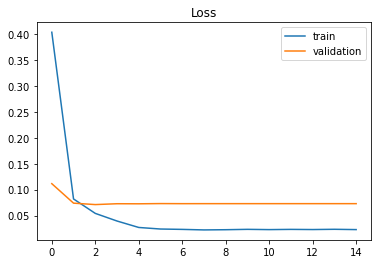

In [59]:
#Plot the loss graph of the model
plt.title('Loss')
plt.plot(models.history['loss'], label='train')
plt.plot(models.history['val_loss'], label='validation')
plt.legend()
plt.show()

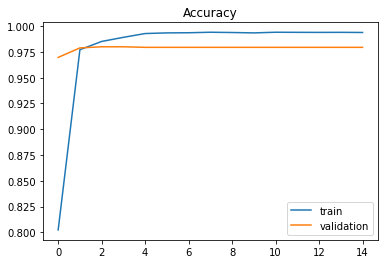

In [60]:
#Plot the accuracy graph of the model
plt.title('Accuracy')
plt.plot(models.history['accuracy'], label='train')
plt.plot(models.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

## Predict the value of y (yhat)

In [61]:
yhat_raw = model.predict(X_test, verbose=0)

# CHECK THE NUMPY ARRAY
yhat_raw

array([[5.6439475e-03, 9.9906701e-01, 9.9994481e-01, 2.8974478e-05,
        4.1303247e-05],
       [9.9092811e-01, 9.9976808e-01, 7.8208745e-05, 3.2278741e-04,
        4.1509015e-04],
       [9.9926943e-01, 5.7323282e-03, 9.9962223e-01, 6.6061279e-05,
        1.6326734e-04],
       ...,
       [9.9941504e-01, 1.4987184e-03, 9.9650025e-01, 2.8911760e-04,
        1.7290710e-02],
       [9.7720599e-01, 9.9512440e-01, 9.9970680e-01, 5.4143079e-06,
        3.0236047e-06],
       [1.7773169e-03, 3.8789317e-04, 9.9991846e-01, 2.0509723e-04,
        9.9726510e-01]], dtype=float32)

In [62]:
# DEBUG to peek at some values
#yhat_raw[777]
#yhat_raw[77]

In [63]:
# CONVERT PREDICTIONS INTO DISCRETE CLASSIFIER (0 OR 1)
# TOLERANCE CONSTANT
TOLERANCE = 0.5

# predicting crisp classes for test set
yhat = [[1 if x > TOLERANCE else 0 for idx,x in enumerate(i)] for i in yhat_raw]
yhat

[[0, 1, 1, 0, 0],
 [1, 1, 0, 0, 0],
 [1, 0, 1, 0, 0],
 [0, 1, 1, 0, 0],
 [0, 1, 1, 0, 0],
 [0, 0, 1, 1, 0],
 [0, 1, 0, 0, 0],
 [1, 0, 0, 1, 0],
 [1, 0, 0, 1, 1],
 [1, 1, 0, 0, 0],
 [1, 1, 0, 0, 0],
 [1, 0, 1, 0, 0],
 [0, 1, 0, 1, 0],
 [1, 0, 0, 1, 0],
 [0, 1, 1, 0, 0],
 [1, 0, 1, 0, 0],
 [1, 1, 0, 0, 0],
 [0, 1, 1, 0, 0],
 [1, 0, 1, 0, 0],
 [0, 1, 0, 0, 0],
 [1, 0, 1, 0, 0],
 [0, 1, 0, 0, 1],
 [0, 0, 1, 0, 0],
 [0, 0, 0, 1, 1],
 [1, 0, 1, 0, 0],
 [0, 0, 1, 0, 0],
 [0, 1, 0, 1, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 1, 0],
 [1, 0, 0, 0, 1],
 [1, 0, 1, 0, 0],
 [0, 0, 1, 0, 0],
 [0, 0, 0, 1, 1],
 [1, 0, 1, 0, 0],
 [1, 0, 1, 0, 0],
 [0, 0, 1, 0, 0],
 [0, 1, 0, 0, 1],
 [0, 1, 0, 1, 1],
 [1, 0, 1, 0, 0],
 [1, 1, 0, 0, 0],
 [0, 0, 0, 1, 0],
 [0, 0, 1, 0, 1],
 [1, 0, 0, 1, 0],
 [0, 0, 1, 0, 0],
 [0, 1, 0, 1, 0],
 [0, 0, 1, 0, 0],
 [0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0],
 [1, 1, 0, 0, 0],
 [0, 1, 1, 0, 0],
 [0, 0, 1, 0, 0],
 [0, 1, 1, 0, 0],
 [0, 0, 1, 0, 0],
 [1, 0, 0,

In [64]:
# DEBUG to peek at some values
#yhat[777]
#yhat[77]

In [65]:
# CONVERT THE YHAT VALUES INTO A PANDAS DATAFRAME
yhat_df = pd.DataFrame(yhat,index=fashion_test_df['id'],columns=train_labels)
yhat_df

,outwear,top,trousers,women dresses,women skirts
id,,,,,
0,0,1,1,0,0
1,1,1,0,0,0
2,1,0,1,0,0
3,0,1,1,0,0
4,0,1,1,0,0
...,...,...,...,...,...
2455,0,0,1,1,0
2456,1,0,1,0,0
2457,1,0,1,0,0


## Export the predictions as a .csv file

In [66]:
# INSERT FILE NAME
FILENAME = 'TEAM_MIA_nlp_predictions'

In [67]:
# EXPORT THE CSV FILE
yhat_df.to_csv('./datasets/{}.csv'.format(FILENAME), index=True)